In [4]:
from bs4 import BeautifulSoup
import requests, re, random, os, csv, math, keras, warnings, datetime
from math import asin, atan2, cos, degrees, radians, sin
import plotly.io as pio
import plotly.express as px
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
import base64

In [2]:
air1 = ["https://uk.flightaware.com/live/flight/AIC213/history/20230324/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230323/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230322/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230321/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230320/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230319/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230318/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230317/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230316/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230315/0140Z/VIDP/VNKT","https://uk.flightaware.com/live/flight/AIC213/history/20230314/0140Z/VIDP/VNKT"]
nep1 = ["https://uk.flightaware.com/live/flight/RNA416/history/20230323/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230322/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230321/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230320/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230319/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230317/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230316/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230315/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230314/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230313/2150Z/WMKK/VNKT","https://uk.flightaware.com/live/flight/RNA416/history/20230312/2150Z/WMKK/VNKT"]

In [3]:
import subprocess
airindialist = []
for i in air1:
    x = subprocess.run("ipython scraping.ipynb AIC213 {}".format(i+"/tracklog"), capture_output=True).stdout
    airindialist.insert(0,x.decode()[:-2])
airindialist

['14-03-2023',
 '15-03-2023',
 '16-03-2023',
 '17-03-2023',
 '18-03-2023',
 '19-03-2023',
 '20-03-2023',
 '21-03-2023',
 '22-03-2023',
 '23-03-2023',
 '24-03-2023']

In [4]:
nepalairwayslist = []

for i in nep1:
    x = subprocess.run("ipython scraping.ipynb RNA416 {}".format(i+"/tracklog"), capture_output=True).stdout
    nepalairwayslist.insert(0,x.decode()[:-2])
nepalairwayslist

['12-03-2023',
 '13-03-2023',
 '14-03-2023',
 '15-03-2023',
 '16-03-2023',
 '17-03-2023',
 '19-03-2023',
 '20-03-2023',
 '21-03-2023',
 '22-03-2023',
 '23-03-2023']

In [5]:
def create_dataset(dataset, look_back, look_ahead):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_ahead):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back + look_ahead - 1, 0])
    return np.array(X), np.array(Y)

def df_creation(flight, file):
    df = pd.read_csv(r'Datasets/{}-{}.csv'.format(flight, file))
    #df_new = df_new.dropna(subset=['Time (IST)']).reset_index(drop=True)
    daylist = np.array(df['Time (IST)'])
    strday = daylist[0][:3]
    df['date_time'] = np.nan
    for j in range(df.shape[0]):
        day2 = daylist[j][:3]
        if(strday==day2):
            df['date_time'][j] = file + daylist[j][3:]
        else:
            if(int(file[:2])!=31):
                df['date_time'][j] = str(int(file[:2]) + 1) + file[2:] + daylist[j][3:]
            else:
                df['date_time'][j] = "01-0" + str(int(file[4])+1) + file[5:] + daylist[j][3:]
    df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M:%S')
    df['day'] = df['date_time'].apply(lambda x: x.day)
    df['hour'] = df['date_time'].apply(lambda x: x.hour)
    df['minute'] = df['date_time'].apply(lambda x: x.minute)
    df['second'] = df['date_time'].apply(lambda x: x.second)
    return df

In [6]:
def model_implementation(files, flight, og):
    dataframelist = []
    for i in files:
        dataframelist.append(df_creation(flight, i))
    if og != None:
        og_df = df_creation(flight, og)
    units = ['Latitude','Longitude','meters']
    units_dict = {}
    predicted_df = dataframelist[-1]
    og_p = []
    for i in units:
        arr = []
        pr = dataframelist[-1][i][:6]
        df_update = dataframelist[0].loc[:,['date_time',i, 'day', 'hour','minute','second', 'Course', 'tilt']]
        for df in dataframelist[1:]:
            df_lat=df.loc[:,['date_time',i, 'day', 'hour','minute','second', 'Course', 'tilt']]
            df_update = pd.concat([df_update, df_lat], axis=0)
        dataset = df_update[i].values #numpy.ndarray
        dataset = dataset.astype('float32')
        dataset = np.reshape(dataset, (-1, 1))
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        test_size = dataframelist[-1].shape[0]
        train_size = len(dataset) - test_size
        train, test = dataset[:train_size,:], dataset[train_size:,:]
        look_back = 5
        look_ahead = 1
        X_train, Y_train = create_dataset(train, look_back, look_ahead)
        X_test, Y_test = create_dataset(test, look_back, look_ahead)
        # reshape input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
        model = Sequential()
        model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        model.add(LSTM(128))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=16, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        # invert predictions
        train_predict = scaler.inverse_transform(train_predict)
        Y_train = scaler.inverse_transform([Y_train])
        test_predict = scaler.inverse_transform(test_predict)
        Y_test = scaler.inverse_transform([Y_test])
        predicted_df[i] = np.append(pr, test_predict[:,0])
        arr.append(f'Train Mean Absolute Error for {i}: {mean_absolute_error(Y_train[0], train_predict[:,0])}')
        arr.append(f'Train Root Mean Squared Error for {i}: {np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))}')
        arr.append(f'Test Mean Absolute Error for {i}: {mean_absolute_error(Y_test[0], test_predict[:,0])}')
        arr.append(f'Test Root Mean Squared Error for {i}: {np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))}')
        fig = plt.figure(figsize=(8,4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Test Loss')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.legend(loc='upper right')
        arr.append(fig)
        aa=[x for x in range(Y_test.shape[1])]
        fig1 = plt.figure(figsize=(8,4))
        plt.plot(aa, Y_test[0][:], marker='.', label="actual")
        plt.plot(aa, test_predict[:,0][:], 'r', label="prediction")
        # plt.tick_params(left=False, labelleft=True) #remove ticks
        plt.tight_layout()
        sns.despine(top=True)
        plt.subplots_adjust(left=0.07)
        plt.ylabel(i, size=15)
        plt.xlabel('Time step', size=15)
        plt.legend(fontsize=10)
        arr.append(fig1)
        units_dict[i] = arr
#         if og != None:
#             og_lat=og_df.loc[:,['date_time',i, 'day', 'hour','minute','second', 'Course', 'tilt']]
#             og_dataset =og_lat[i].values #numpy.ndarray
#             og_dataset = og_dataset.astype('float32')
#             og_dataset = np.reshape(og_dataset, (-1, 1))
#             og_test = scaler.transform(og_dataset)
#             og_test = np.reshape(og_test, (og_test.shape[0], 1, og_test.shape[1]))
#             og_predict = model.predict(og_test)
#             og_predict = scaler.inverse_transform(og_predict)
#             og_p.append("The next {} is: {}".format(i, og_predict[-1,0]))
    predicted_df.to_csv(r"Datasets/{}-{}.csv".format(flight, 'Predicted'), index = False)
    return units_dict, og_p

Epoch 1/16
49/49 [==============================] - 8s 29ms/step - loss: 0.0518 - val_loss: 0.0038
Epoch 2/16
49/49 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 3/16
49/49 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 4/16
49/49 [==============================] - 0s 9ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 5/16
49/49 [==============================] - 1s 13ms/step - loss: 0.0036 - val_loss: 7.8348e-04
Epoch 6/16
49/49 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 6.1708e-04
Epoch 7/16
49/49 [==============================] - 1s 11ms/step - loss: 0.0029 - val_loss: 5.9214e-04
Epoch 8/16
49/49 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 8.7047e-04
Epoch 9/16
49/49 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 2.8860e-04
Epoch 10/16
49/49 [==============================] - 1s 11ms/step - loss: 0.0022 - val_los

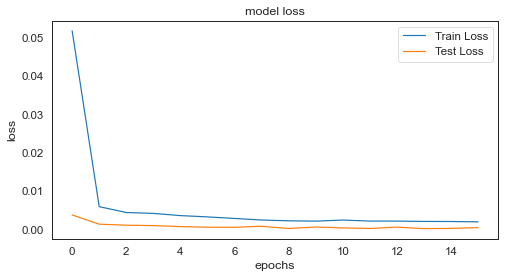

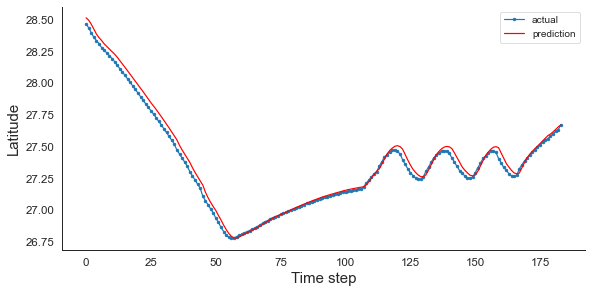

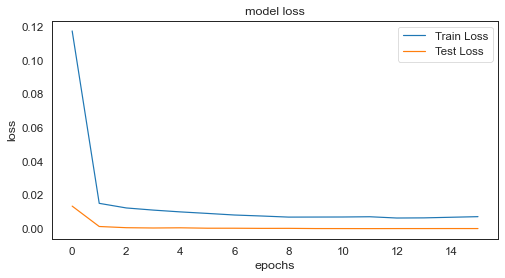

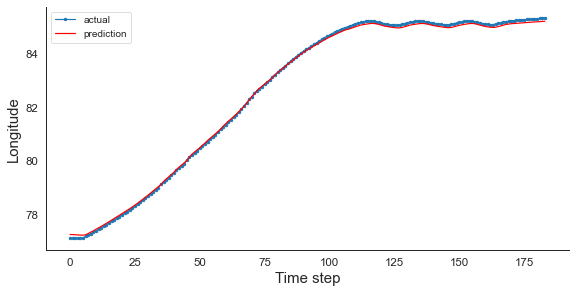

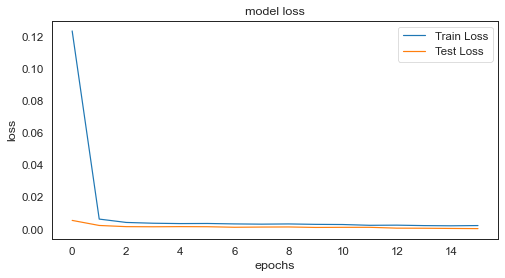

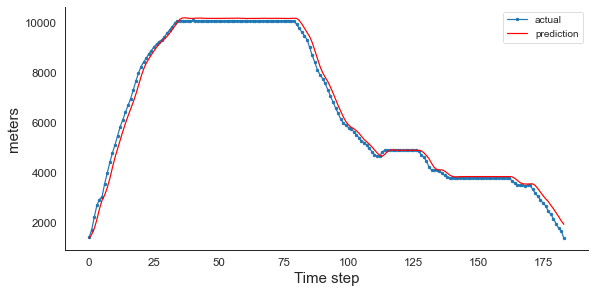

In [7]:
results1, og_p1 = model_implementation(airindialist, 'AIC213', None)

In [8]:
for i in results1.keys():
    print("For", i)
    for j in results1[i][:-2]:
        print(j)
    f1 = results1[i][-2]
    plt.show()
    f2 = results1[i][-1]
    plt.show()

For Latitude
Train Mean Absolute Error for Latitude: 0.039920816886018846
Train Root Mean Squared Error for Latitude: 0.0785640379897687
Test Mean Absolute Error for Latitude: 0.03272912095006395
Test Root Mean Squared Error for Latitude: 0.04169809818937907
For Longitude
Train Mean Absolute Error for Longitude: 0.11859545949208523
Train Root Mean Squared Error for Longitude: 0.6307894404500531
Test Mean Absolute Error for Longitude: 0.0679150158412292
Test Root Mean Squared Error for Longitude: 0.07717316622163738
For meters
Train Mean Absolute Error for meters: 248.01559487246527
Train Root Mean Squared Error for meters: 300.6594276682307
Test Mean Absolute Error for meters: 180.52302503729018
Test Root Mean Squared Error for meters: 237.41043987380775


Epoch 1/16
155/155 [==============================] - 6s 13ms/step - loss: 0.0293 - val_loss: 0.0015
Epoch 2/16
155/155 [==============================] - 1s 8ms/step - loss: 0.0052 - val_loss: 1.2507e-04
Epoch 3/16
155/155 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 1.6693e-04
Epoch 4/16
155/155 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 2.8157e-05
Epoch 5/16
155/155 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 6.9473e-04
Epoch 6/16
155/155 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 3.5835e-04
Epoch 7/16
155/155 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 8.3632e-04
Epoch 8/16
155/155 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 2.7847e-04
Epoch 9/16
17/17 [==============================] - 0s 2ms/step
Epoch 1/16
155/155 [==============================] - 4s 12ms/step - loss: 0.0473 - val_loss: 4.3865e-04
E

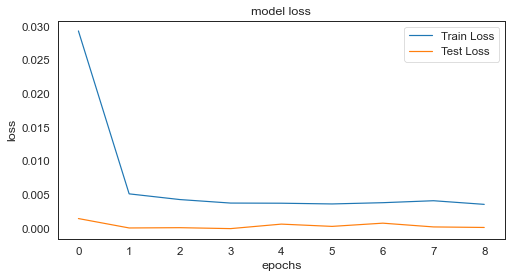

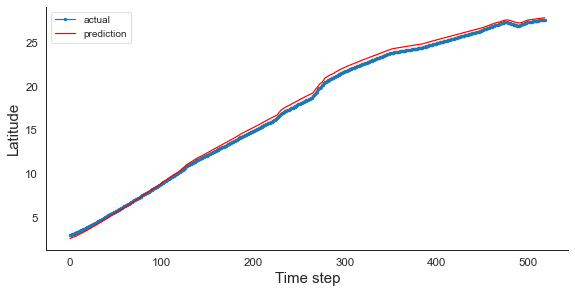

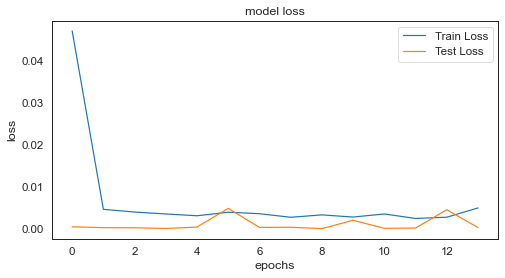

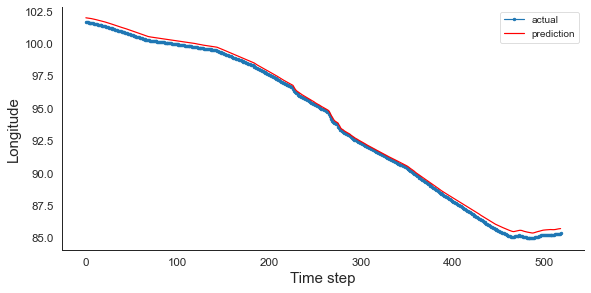

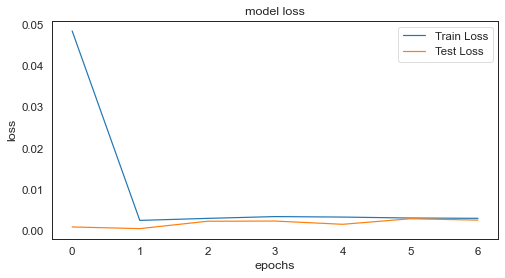

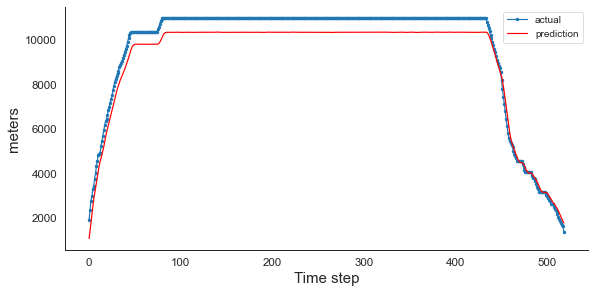

In [9]:
results2, og_p2 = model_implementation(nepalairwayslist, 'RNA416', None)

In [10]:
for i in results2.keys():
    print("For", i)
    for j in results2[i][:-2]:
        print(j)
    f1 = results2[i][-2]
    plt.show()
    f2 = results2[i][-1]
    plt.show()

For Latitude
Train Mean Absolute Error for Latitude: 0.3834660804776603
Train Root Mean Squared Error for Latitude: 1.166846771448671
Test Mean Absolute Error for Latitude: 0.3305745126484022
Test Root Mean Squared Error for Latitude: 0.355895692411472
For Longitude
Train Mean Absolute Error for Longitude: 0.31674675071797304
Train Root Mean Squared Error for Longitude: 0.754090221409982
Test Mean Absolute Error for Longitude: 0.2698169200271047
Test Root Mean Squared Error for Longitude: 0.28204931136288475
For meters
Train Mean Absolute Error for meters: 553.2522598444891
Train Root Mean Squared Error for meters: 586.8818919397238
Test Mean Absolute Error for meters: 568.3782964711256
Test Root Mean Squared Error for meters: 597.6341937385687


In [5]:
df1 = pd.read_csv(r"Datasets/AIC213-24-03-2023.csv")
df1['Flight'] = ['AIC213' for i in range(df1.shape[0])]
df1

,Time (IST),Latitude,Longitude,Course,kts,mph,meters,Rate,Reporting Facility,Time Diff,m/s,Dist from lp,tilt,Flight
0,Fri 07:11:05,28.5361,77.1179,108.0000,152.0000,175.0000,686.0000,540.0000,FlightAware ADS-B (DEL / VIDP),0.0000,77.7778,0.0000,0.0000,AIC213
1,Fri 07:11:22,28.5287,77.1292,147.0000,161.0000,185.0000,808.0000,374.0000,FlightAware ADS-B (VIDX),17.0000,82.2222,1397.7778,5.0072,AIC213
2,Fri 07:11:38,28.5168,77.1319,186.0000,178.0000,205.0000,892.0000,329.0000,FlightAware ADS-B (VIDD),16.0000,91.1111,1457.7778,3.3033,AIC213
3,Fri 07:11:54,28.5034,77.1291,191.0000,198.0000,228.0000,983.0000,482.0000,FlightAware ADS-B (DEL / VIDP),16.0000,101.3333,1621.3333,3.2175,AIC213
4,Fri 07:12:14,28.4839,77.1253,189.0000,215.0000,247.0000,1181.0000,667.0000,FlightAware ADS-B (DEL / VIDP),20.0000,109.7778,2195.5556,5.1741,AIC213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Fri 08:40:25,27.5998,85.3150,22.0000,147.0000,169.0000,1951.0000,-373.0000,FlightAware ADS-B (KTM / VNKT),30.0000,75.1111,2253.3333,-4.6583,AIC213
186,Fri 08:40:55,27.6193,85.3242,22.0000,145.0000,167.0000,1760.0000,-364.0000,FlightAware ADS-B (KTM / VNKT),30.0000,74.2222,2226.6667,-4.9208,AIC213
187,Fri 08:41:14,27.6309,85.3293,21.0000,143.0000,165.0000,1654.0000,-276.0000,Surface and Near-Surface,19.0000,73.3333,1393.3333,-4.3631,AIC213
188,Fri 08:42:21,27.6717,85.3479,22.0000,140.0000,161.0000,1364.0000,-242.0000,FlightAware ADS-B (KTM / VNKT),67.0000,71.5556,4794.2222,-3.4679,AIC213


In [6]:
df2 = pd.read_csv(r"Datasets/RNA416-23-03-2023.csv")
df2['Flight'] = ['RNA416' for i in range(df2.shape[0])]
df2

,Time (IST),Latitude,Longitude,Course,kts,mph,meters,Rate,Reporting Facility,Time Diff,m/s,Dist from lp,tilt,Flight
0,Fri 03:46:28,2.7659,101.7103,326.0000,173.0000,199.0000,61.0000,0.0000,Surface and Near-Surface,0.0000,88.4444,0.0000,0.0000,RNA416
1,Fri 03:47:40,2.8189,101.6834,344.0000,197.0000,227.0000,747.0000,509.0000,FlightAware ADS-B (SZB / WMSA),72.0000,100.8889,7264.0000,5.4190,RNA416
2,Fri 03:47:56,2.8338,101.6796,346.0000,219.0000,252.0000,808.0000,378.0000,FlightAware ADS-B (KUL / WMKK),16.0000,112.0000,1792.0000,1.9507,RNA416
3,Fri 03:48:26,2.8667,101.6714,346.0000,260.0000,299.0000,1036.0000,671.0000,FlightAware ADS-B (SZB / WMSA),30.0000,132.8889,3986.6667,3.2786,RNA416
4,Fri 03:48:56,2.9026,101.6625,346.0000,272.0000,313.0000,1478.0000,877.0000,FlightAware ADS-B (SZB / WMSA),30.0000,139.1111,4173.3333,6.0796,RNA416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Fri 08:30:17,27.6083,85.3107,46.0000,151.0000,174.0000,1753.0000,-234.0000,FlightAware ADS-B (KTM / VNKT),21.0000,77.3333,1624.0000,-3.2122,RNA416
521,Fri 08:30:37,27.6189,85.3210,37.0000,151.0000,174.0000,1684.0000,-206.0000,FlightAware ADS-B (KTM / VNKT),20.0000,77.3333,1546.6667,-2.5569,RNA416
522,Fri 08:30:57,27.6303,85.3287,27.0000,151.0000,174.0000,1615.0000,-213.0000,Surface and Near-Surface,20.0000,77.3333,1546.6667,-2.5569,RNA416
523,Fri 08:32:03,27.6716,85.3479,21.0000,143.0000,165.0000,1379.0000,-218.0000,FlightAware ADS-B (KTM / VNKT),66.0000,73.3333,4840.0000,-2.7949,RNA416


In [7]:
df = pd.concat([df1,df2], ignore_index = True)
df

,Time (IST),Latitude,Longitude,Course,kts,mph,meters,Rate,Reporting Facility,Time Diff,m/s,Dist from lp,tilt,Flight
0,Fri 07:11:05,28.5361,77.1179,108.0000,152.0000,175.0000,686.0000,540.0000,FlightAware ADS-B (DEL / VIDP),0.0000,77.7778,0.0000,0.0000,AIC213
1,Fri 07:11:22,28.5287,77.1292,147.0000,161.0000,185.0000,808.0000,374.0000,FlightAware ADS-B (VIDX),17.0000,82.2222,1397.7778,5.0072,AIC213
2,Fri 07:11:38,28.5168,77.1319,186.0000,178.0000,205.0000,892.0000,329.0000,FlightAware ADS-B (VIDD),16.0000,91.1111,1457.7778,3.3033,AIC213
3,Fri 07:11:54,28.5034,77.1291,191.0000,198.0000,228.0000,983.0000,482.0000,FlightAware ADS-B (DEL / VIDP),16.0000,101.3333,1621.3333,3.2175,AIC213
4,Fri 07:12:14,28.4839,77.1253,189.0000,215.0000,247.0000,1181.0000,667.0000,FlightAware ADS-B (DEL / VIDP),20.0000,109.7778,2195.5556,5.1741,AIC213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,Fri 08:30:17,27.6083,85.3107,46.0000,151.0000,174.0000,1753.0000,-234.0000,FlightAware ADS-B (KTM / VNKT),21.0000,77.3333,1624.0000,-3.2122,RNA416
711,Fri 08:30:37,27.6189,85.3210,37.0000,151.0000,174.0000,1684.0000,-206.0000,FlightAware ADS-B (KTM / VNKT),20.0000,77.3333,1546.6667,-2.5569,RNA416
712,Fri 08:30:57,27.6303,85.3287,27.0000,151.0000,174.0000,1615.0000,-213.0000,Surface and Near-Surface,20.0000,77.3333,1546.6667,-2.5569,RNA416
713,Fri 08:32:03,27.6716,85.3479,21.0000,143.0000,165.0000,1379.0000,-218.0000,FlightAware ADS-B (KTM / VNKT),66.0000,73.3333,4840.0000,-2.7949,RNA416


In [11]:
%matplotlib notebook
fig = px.line_3d(df, x="Longitude", y = "Latitude", z="meters", color='Flight', color_discrete_map={'AIC213':'blue','RNA416':'red'})
fig.show()
fig.write_html("image.html")